In [1]:
import MySQLdb as mdb
import os
import pandas as pd
import numpy as np

In [2]:
%run '../../code/constants.py'

In [3]:
# ssh -L 9999:dbreplica.us-east-1.int.smartpaylease.com:3306 xwei@10.128.1.27

In [4]:
user = "risk"
host = '127.0.0.1'
port = 9999
db = 'billfloat_production'
password = os.environ['mysqlpw']

In [5]:
db = mdb.connect( host=host, user=user, passwd=password, db=db, port=port)
cur = db.cursor()

In [81]:
# mysql_begin_date is for model
# mysql_check_date is for model validation
with open('../../code/retro_financial.sql', 'r') as f:
    sql_str = f.read().format(bd=mysql_begin_date)
#     sql_str = f.read().format(bd=mysql_check_date)
print (sql_str)

select substring(cast(week_ending_dt as char), 6) as dt, sum(case when fpd = 1 then apps else 0 end) as fpd_count
    , sum(case when fpd = 1 then apps else 0 end)/sum(apps) as fpd
    , sum(fpd * approval_amount)/sum(approval_amount) as approval_fpd
    , sum(fpd * originations) / sum(originations) as origination_fpd
    , sum(approval_amount) as approval_amount, sum(originations) as originations
    , sum(apps) as apps
from (
    select date_sub(date_add(loan_application_created_date, interval 6 day) , interval dayofweek(loan_application_created_date) day) as week_ending_dt
        , case when first_inst_amount_60dpd - first_inst_amount_paid_60dpd > 1  or chargeback_amount > 0 then 1 else 0 end as fpd
        , sum(approval_amount) as approval_amount
        , sum(outgoing_payment_amount) as originations
        , count(*) as apps
    from lease_summaries
    where merchant_id_transaction = 3 and user_id in (select r_user_id from mongo_handsets where de_need_bank_verification = 1)
  

In [82]:
df = pd.read_sql(sql_str, db)

In [83]:
print (df.shape)

(22, 8)


In [84]:
df.head()

dt  fpd_count     fpd  approval_fpd  origination_fpd  approval_amount  \
0  02-09        8.0  0.1356      0.110706         0.136690          41100.0   
1  02-16       14.0  0.1750      0.141248         0.179860          57700.0   
2  02-23       15.0  0.1304      0.122214         0.136111          78960.0   
3  03-02        8.0  0.0714      0.079523         0.073626          80480.0   
4  03-09        7.0  0.0854      0.088971         0.114072          59570.0   

   originations   apps  
0      32833.82   59.0  
1      40985.62   80.0  
2      63300.75  115.0  
3      68529.83  112.0  
4      47007.52   82.0

In [85]:
fp = '../../data/exp_data/retro_financial.pkl'
# fp = path + msql_check

In [86]:
df.to_pickle(fp)

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

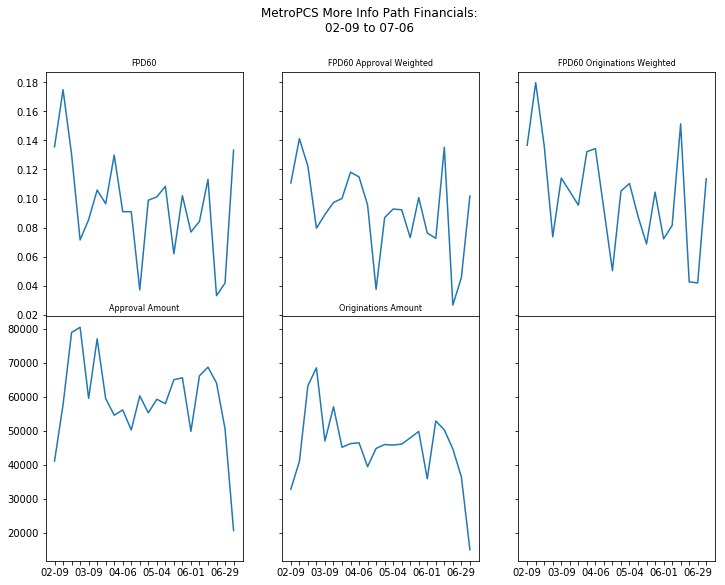

In [88]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = \
            plt.subplots(2, 3, sharex=True, sharey='row', figsize=(12, 9))
f.suptitle('MetroPCS More Info Path Financials:\n{0} to {1}'.format(
    df.dt.min(), df.dt.max(), fontsize=14))
ax1.set_title("FPD60", fontsize=8)
ax1.plot(df.dt, df.fpd)
ax2.set_title('FPD60 Approval Weighted', fontsize=8)
ax2.plot(df.dt, df.approval_fpd)
ax3.set_title('FPD60 Originations Weighted', fontsize=8)
ax3.plot(df.dt, df.origination_fpd)
ax4.set_title('Approval Amount', fontsize=8)
ax4.plot(df.dt, df.approval_amount)
ax5.set_title('Originations Amount', fontsize=8)
ax5.plot(df.dt, df.originations)
f.subplots_adjust(hspace=0)
# plt.setp([a.get_yticklabels() for a in f.axes[[1,2,4,5]]], visible=False)
for ax in [ax4, ax5, ax6]:
    for i, label in enumerate(ax.xaxis.get_ticklabels()):
        if i % 4 != 0:
            label.set_visible(False)
f.savefig('../../data/exp_data/retr_financial_graph.png')